
--- HEAD ---
  N   P   K   pH   EC   OC    S   Zn   Fe   Cu   Mn    B  Output
138 8.6 560 7.46 0.62 0.70  5.9 0.24 0.31 0.77 8.71 0.11       0
213 7.5 338 7.62 0.75 1.06 25.4 0.30 0.86 1.54 2.89 2.29       0
163 9.6 718 7.59 0.51 1.11 14.3 0.30 0.86 1.57 2.70 2.03       0
157 6.8 475 7.64 0.58 0.94 26.0 0.34 0.54 1.53 2.65 1.82       0
220 8.6 444 7.43 0.65 0.72 11.7 0.37 0.66 0.90 2.19 1.82       0

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
Index: 1041 entries, 0 to 491
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       1041 non-null   int64  
 1   P       1041 non-null   float64
 2   K       1041 non-null   int64  
 3   pH      1041 non-null   float64
 4   EC      1041 non-null   float64
 5   OC      1041 non-null   float64
 6   S       1041 non-null   float64
 7   Zn      1041 non-null   float64
 8   Fe      1041 non-null   float64
 9   Cu      1041 non-null   float64
 10  Mn      1041 non-null   float64


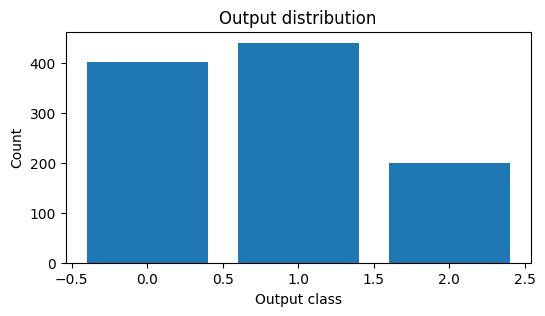

Filtered out 325 outlier rows
Class distribution before balancing:
Output
0    311
1    309
2     96
Name: count, dtype: int64
Class distribution after balancing:
Output
2    311
0    311
1    311
Name: count, dtype: int64

Shapes -> Train: (596, 12) Val: (150, 12) Test: (187, 12)
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/tmp/ipython-input-4218896550.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Best params: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

== Validation accuracy: 0.9933
              precision    recall  f1-score   support

           0     0.9804    1.0000    0.9901        50
           1     1.0000    0.9800    0.9899        50
           2     1.0000    1.0000    1.0000        50

    accuracy                         0.9933       150
   macro avg     0.9935    0.9933    0.9933       150
weighted avg     0.9935    0.9933    0.9933       150

Confusion matrix:
 [[50  0  0]
 [ 1 49  0]
 [ 0  0 50]]


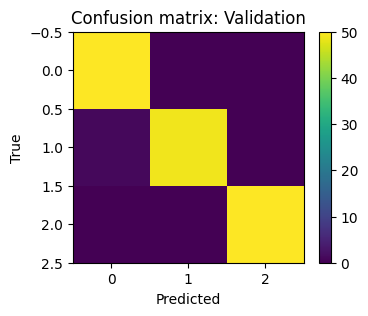

ROC AUC (macro): 0.9979

== Test accuracy: 0.9840
              precision    recall  f1-score   support

           0     0.9839    0.9839    0.9839        62
           1     0.9836    0.9677    0.9756        62
           2     0.9844    1.0000    0.9921        63

    accuracy                         0.9840       187
   macro avg     0.9840    0.9839    0.9839       187
weighted avg     0.9840    0.9840    0.9839       187

Confusion matrix:
 [[61  1  0]
 [ 1 60  1]
 [ 0  0 63]]


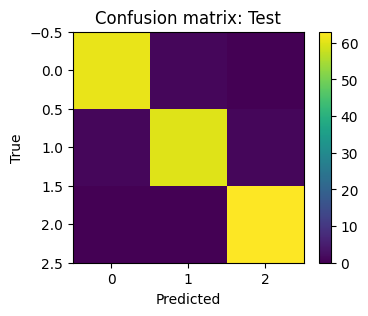

ROC AUC (macro): 0.9992
Model saved to ./outputs/optimized_fertilizer_model.joblib
Scaler saved to ./outputs/minmax_scaler.joblib
Test prediction report saved to ./outputs/test_predictions_report.csv


In [5]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import resample
import joblib


def create_synthetic(csv_path):
    np.random.seed(42)
    n = 2000
    N = np.random.normal(loc=50, scale=15, size=n).clip(0, 120)
    P = np.random.normal(loc=30, scale=10, size=n).clip(0, 80)
    K = np.random.normal(loc=40, scale=12, size=n).clip(0, 120)
    pH = np.random.normal(loc=6.5, scale=0.6, size=n).clip(4.0, 9.0)
    temp = np.random.normal(loc=25, scale=5, size=n).clip(-5, 45)
    humidity = np.random.normal(loc=60, scale=15, size=n).clip(5, 100)
    moisture = np.random.normal(loc=30, scale=10, size=n).clip(0, 100)
    sunlight = np.random.normal(loc=8, scale=2, size=n).clip(0, 16)
    prev_yield = np.random.normal(loc=3, scale=1, size=n).clip(0.2, 8)
    crop_types = np.random.choice(['rice','wheat','maize','soybean'], size=n, p=[0.35,0.35,0.2,0.1])
    score = (100 - N) * 0.25 + (60 - P) * 0.2 + (60 - K) * 0.2 + (6.5 - pH) * 5 + (30 - moisture) * 0.1 - prev_yield * 2
    norm = (score - score.min()) / (score.max() - score.min())
    labels = pd.cut(norm, bins=[-0.01, 0.33, 0.66, 1.01], labels=[0,1,2]).astype(int)

    df = pd.DataFrame({
        'N': N, 'P': P, 'K': K, 'pH': pH, 'Temperature': temp,
        'Humidity': humidity, 'Moisture': moisture, 'Sunlight': sunlight,
        'Prev_Yield': prev_yield, 'Crop': crop_types, 'Output': labels
    })
    # Insert a few missing values
    for col in ['P','K','pH','Moisture']:
        mask = np.random.rand(n) < 0.03
        df.loc[mask, col] = np.nan
    df.to_csv(csv_path, index=False)
    print(f"Synthetic dataset saved to {csv_path}")
    return csv_path


def load_data(data_path):
    # try multiple common defaults
    tried = []
    for p in [data_path, '/content/dataset1.csv', '/mnt/data/dataset1.csv']:
        if p is None:
            continue
        tried.append(p)
        if os.path.exists(p):
            print(f"Loading data from: {p}")
            return pd.read_csv(p)
    # if none found, create synthetic dataset at provided path or /mnt/data/dataset1.csv
    fallback = data_path or '/mnt/data/dataset1.csv'
    os.makedirs(os.path.dirname(fallback), exist_ok=True)
    create_synthetic(fallback)
    print(f"Loading synthetic data from: {fallback}")
    return pd.read_csv(fallback)


def eda(df):
    print('\n--- HEAD ---')
    print(df.head().to_string(index=False))
    print('\n--- INFO ---')
    print(df.info())
    print('\n--- DESCRIBE ---')
    print(df.describe().T.round(3))
    # simple histogram for Output
    if 'Output' in df.columns:
        plt.figure(figsize=(6,3))
        plt.hist(df['Output'].dropna(), bins=[-0.5,0.5,1.5,2.5], rwidth=0.8)
        plt.title('Output distribution')
        plt.xlabel('Output class')
        plt.ylabel('Count')
        plt.show()


def preprocess(df):
    # Impute missing values
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col].fillna(df[col].median(), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Outlier removal by IQR on numeric columns (not Output)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Output' in num_cols:
        num_cols.remove('Output')
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = ~((df[num_cols] < lower) | (df[num_cols] > upper)).any(axis=1)
    filtered = df[mask].copy()
    print(f"Filtered out {df.shape[0] - filtered.shape[0]} outlier rows")

    # Balance classes via upsampling
    print('Class distribution before balancing:')
    print(filtered['Output'].value_counts())
    maj = filtered['Output'].value_counts().max()
    parts = []
    for cls in sorted(filtered['Output'].unique()):
        subset = filtered[filtered['Output'] == cls]
        if subset.shape[0] < maj:
            subset = resample(subset, replace=True, n_samples=maj, random_state=42)
        parts.append(subset)
    balanced = pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)
    print('Class distribution after balancing:')
    print(balanced['Output'].value_counts())

    # Encode categorical
    if 'Crop' in balanced.columns:
        le = LabelEncoder()
        balanced['Crop_enc'] = le.fit_transform(balanced['Crop'])
        balanced.drop(columns=['Crop'], inplace=True)
    else:
        le = None

    # Split features and labels
    y = balanced['Output']
    X = balanced.drop('Output', axis=1)

    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X_scaled, y, scaler, le


def train_and_evaluate(X, y, out_dir):
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
    print('\nShapes -> Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grid = {'n_estimators':[100,200], 'max_depth':[6,12,None], 'min_samples_split':[2,5]}
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best = grid.best_estimator_

    def evaluate(model, Xs, ys, name):
        preds = model.predict(Xs)
        acc = accuracy_score(ys, preds)
        print(f"\n== {name} accuracy: {acc:.4f}")
        print(classification_report(ys, preds, digits=4))
        cm = confusion_matrix(ys, preds)
        print('Confusion matrix:\n', cm)
        plt.figure(figsize=(4,3))
        plt.imshow(cm, interpolation='nearest')
        plt.title(f'Confusion matrix: {name}')
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        if hasattr(model, 'predict_proba'):
            try:
                probs = model.predict_proba(Xs)
                auc = roc_auc_score(pd.get_dummies(ys), probs, average='macro', multi_class='ovr')
                print('ROC AUC (macro):', round(auc,4))
            except Exception as e:
                print('ROC AUC not computed:', e)

    evaluate(best, X_val, y_val, 'Validation')
    evaluate(best, X_test, y_test, 'Test')

    # Save model
    os.makedirs(out_dir, exist_ok=True)
    model_path = os.path.join(out_dir, 'optimized_fertilizer_model.joblib')
    joblib.dump(best, model_path)
    print('Model saved to', model_path)

    return best, X_test, y_test


def main(df, out_dir):
    eda(df)
    X, y, scaler, label_enc = preprocess(df)
    model, X_test, y_test = train_and_evaluate(X, y, out_dir)

    # save scaler and a small test-predictions CSV
    scaler_path = os.path.join(out_dir, 'minmax_scaler.joblib')
    joblib.dump(scaler, scaler_path)
    print('Scaler saved to', scaler_path)

    preds = model.predict(X_test)
    report = X_test.copy()
    report['True'] = y_test.values
    report['Pred'] = preds
    report_path = os.path.join(out_dir, 'test_predictions_report.csv')
    report.to_csv(report_path, index=False)
    print('Test prediction report saved to', report_path)

# Call main with the 'Data' variable already loaded in the notebook
main(Data, './outputs')